In [19]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt

In [20]:
# create node positions
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions

# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)

print(edge_src.shape)

edge_vec = pos[edge_dst] - pos[edge_src]

# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([3356])


33.56

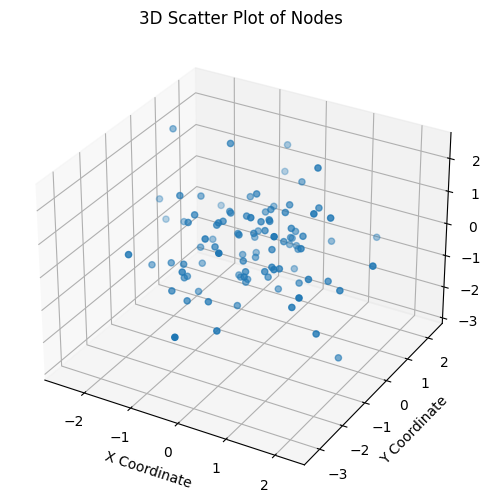

In [21]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Re-creating the positions using the given code snippet
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions

# Creating a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

ax.set_title("3D Scatter Plot of Nodes")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")

plt.show()


In [22]:
irreps_input = o3.Irreps("10x0e + 10x1e")
irreps_output = o3.Irreps("20x0e + 10x1e")
f_in = irreps_input.randn(num_nodes, -1)

In [23]:
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)
print(irreps_sh)

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')

1x0e+1x1o+1x2e


FullyConnectedTensorProduct(10x0e+10x1e x 1x0e+1x1o+1x2e -> 20x0e+10x1e | 400 paths | 400 weights) needs 400 weights


C:\Users\MartinKaras(AI)\AppData\Roaming\Python\Python38\site-packages\torch\jit\_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>, <Axes: >)

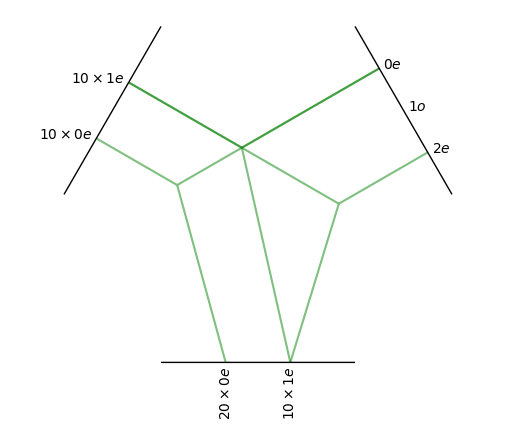

In [24]:
tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

print(f"{tp} needs {tp.weight_numel} weights")

tp.visualize()

# RADIAL BASIS FUNCTION EMBEDDING

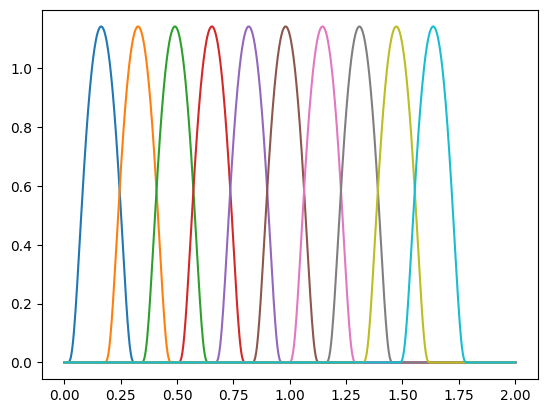

In [7]:
num_basis = 10

x = torch.linspace(0.0, 2.0, 1000)
y = soft_one_hot_linspace(
    x,
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)

plt.plot(x, y)

In [8]:
edge_length_embedding = soft_one_hot_linspace(
    edge_vec.norm(dim=1),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)
edge_length_embedding = edge_length_embedding.mul(num_basis**0.5)

print(edge_length_embedding.shape)
edge_length_embedding.pow(2).mean()  # the second moment

torch.Size([3806, 10])


tensor(0.9091)

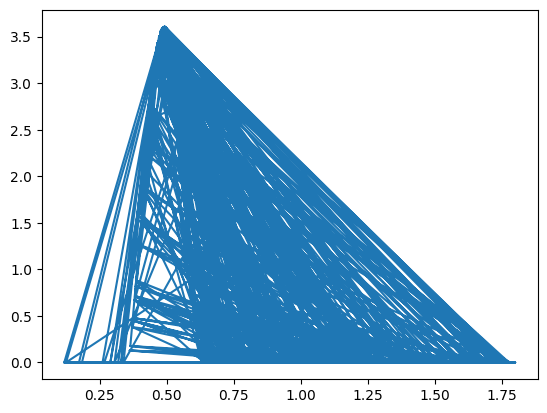

In [9]:
plt.plot(edge_vec.norm(dim=1), edge_length_embedding[:,2])

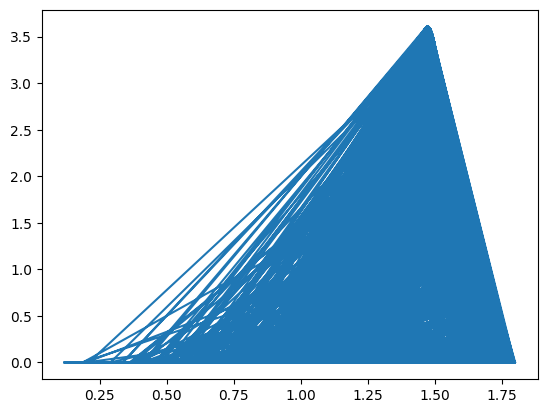

In [10]:
plt.plot(edge_vec.norm(dim=1), edge_length_embedding[:,8])

# MLP PART
## [input layer 10, hidden layer 16, output layer 400]

the network is learning more complex representation of the edge lengths
we have just an distance vector as input [3630, 1], then we embed that input [3630, 10]
then the NN creates even more complex representations [3630, 400]   

In [11]:
fc = nn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)
weight = fc(edge_length_embedding)

print(weight.shape)
print(len(edge_src), tp.weight_numel)

# For a proper notmalization, the weights also need to be mean 0
print(weight.mean(), weight.std())  # should close to 0 and 1

torch.Size([3806, 400])
3806 400
tensor(-3.1117e-05, grad_fn=<MeanBackward0>) tensor(1.0859, grad_fn=<StdBackward0>)


# Now we find relationship between edges, nodes and spherical harmonics
$$
f_j \; \otimes\!(h(\|x_{ij}\|)) \; Y(x_{ij} / \|x_{ij}\|)
$$

f_in is value of the node

In [12]:
summand = tp(f_in[edge_src], sh, fc(edge_length_embedding))

print(summand.shape)
print(summand.pow(2).mean())  # should be close to 1

torch.Size([3806, 50])
tensor(1.2182, grad_fn=<MeanBackward0>)


In [13]:
wtf = fc(edge_length_embedding)

In [14]:
zzz = f_in[edge_src]

In [15]:
f_out = scatter(summand, edge_dst, dim=0, dim_size=num_nodes)

f_out = f_out.div(num_neighbors**0.5)

f_out.pow(2).mean()  # should be close to 1

tensor(1.3867, grad_fn=<MeanBackward0>)